# 1. Imports & Setup

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")

DATA_DIR = "data/processed"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

TICKERS = ["TSLA", "BND", "SPY"]
TEST_SIZE = 30
SEQ_LENGTH = 30

# 2. Helper function: Train/test split for time series

In [9]:
def train_test_split(ts, test_size=TEST_SIZE):
    train = ts.iloc[:-test_size]
    test = ts.iloc[-test_size:]
    return train, test

# 3. Helper function: Create sequences for LSTM

In [10]:
def create_sequences(data, seq_length=SEQ_LENGTH):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


# 4. ARIMA model training and forecasting

In [11]:
def arima_forecast(ts, order=(1,1,1), steps=TEST_SIZE):
    model = ARIMA(ts, order=order)
    model_fit = model.fit()
    forecast_result = model_fit.get_forecast(steps=steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()
    return forecast, conf_int, model_fit.aic

# 5. LSTM model building, training, forecasting

In [12]:
def lstm_forecast(train_ts, test_ts, seq_length=SEQ_LENGTH, epochs=100):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_ts.values.reshape(-1,1))
    test_scaled = scaler.transform(test_ts.values.reshape(-1,1))

    X_train, y_train = create_sequences(train_scaled, seq_length)
    test_full = np.concatenate((train_scaled[-seq_length:], test_scaled), axis=0)
    X_test, y_test = create_sequences(test_full, seq_length)

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length,1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=0.1,
                        epochs=epochs,
                        batch_size=32,
                        callbacks=[early_stop],
                        verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    return y_test_orig, y_pred

# 6. Main loop: Run ARIMA & LSTM for each ticker

In [14]:
arima_results = []
lstm_results = []
all_forecasts = []

for ticker in TICKERS:
    print(f"\nProcessing {ticker}...")

    file_path = os.path.join(DATA_DIR, f"{ticker}_processed.csv")
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    ts = df['log_adjclose'].dropna()

    # Split into train and test sets
    train_ts, test_ts = train_test_split(ts, TEST_SIZE)

    # ARIMA forecast
    arima_order = {
        "TSLA": (2, 0, 1),
        "BND": (1, 1, 2),
        "SPY": (3, 1, 3)
    }[ticker]

    forecast_arima, conf_int, aic = arima_forecast(train_ts, order=arima_order, steps=TEST_SIZE)

    # Align forecast and confidence interval index with test set index
    forecast_arima.index = test_ts.index
    conf_int.index = test_ts.index

    # Calculate ARIMA metrics
    mae_arima = mean_absolute_error(test_ts, forecast_arima)
    rmse_arima = np.sqrt(mean_squared_error(test_ts, forecast_arima))

    arima_results.append({
        "Ticker": ticker,
        "p": arima_order[0],
        "d": arima_order[1],
        "q": arima_order[2],
        "AIC": aic,
        "MAE": mae_arima,
        "RMSE": rmse_arima
    })

    # LSTM forecast (assumes lstm_forecast returns actual and predicted arrays)
    y_test_orig, y_pred = lstm_forecast(train_ts, test_ts)

    # Calculate LSTM metrics
    mae_lstm = mean_absolute_error(y_test_orig, y_pred)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_orig, y_pred))

    lstm_results.append({
        "Ticker": ticker,
        "MAE": mae_lstm,
        "RMSE": rmse_lstm
    })

    # Prepare combined DataFrame for actual vs forecasts
    df_forecast = pd.DataFrame({
        "Actual": test_ts,
        "ARIMA_Forecast": forecast_arima,
        "LSTM_Forecast": pd.Series(y_pred, index=test_ts.index)
    })

    all_forecasts.append(df_forecast)



Processing TSLA...


C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Processing BND...


C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

Processing SPY...


C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


# 7. Show metrics comparison

In [15]:
arima_df = pd.DataFrame(arima_results)
lstm_df = pd.DataFrame(lstm_results)

print("\nARIMA Results:")
display(arima_df)

print("\nLSTM Results:")
display(lstm_df)

# Save metrics
arima_df.to_csv(os.path.join(RESULTS_DIR, "metrics_arima.csv"), index=False)
lstm_df.to_csv(os.path.join(RESULTS_DIR, "metrics_lstm.csv"), index=False)


ARIMA Results:


,Ticker,p,d,q,AIC,MAE,RMSE
0,TSLA,2,0,1,1156.309230,0.248260,0.297978
1,BND,1,1,2,1296.518058,0.127085,0.152750
2,SPY,3,1,3,701.642549,0.131102,0.159932



LSTM Results:


,Ticker,MAE,RMSE
0,TSLA,0.224514,0.287120
1,BND,0.122425,0.156987
2,SPY,0.142235,0.165701


# 8. Plot actual vs forecast for each ticker

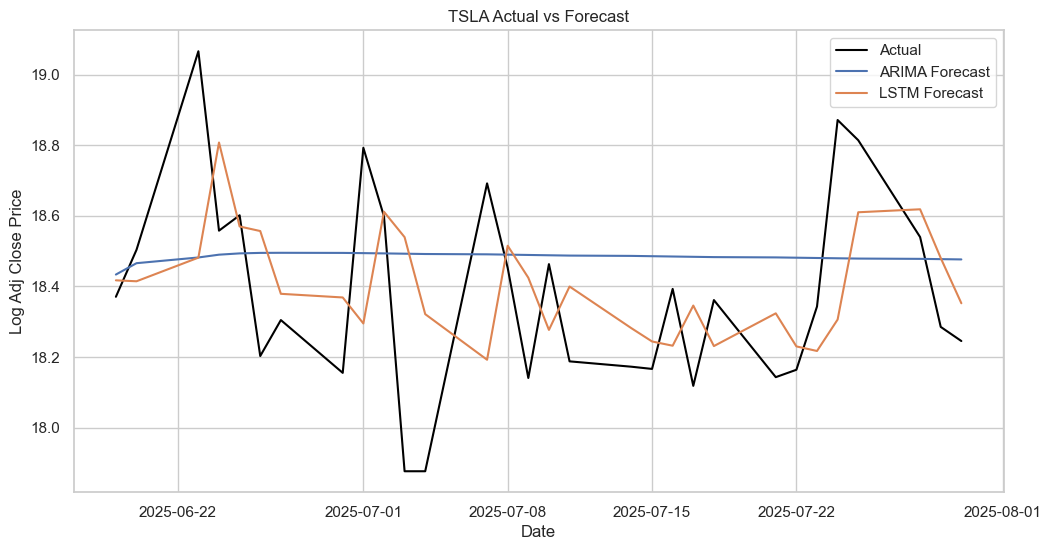

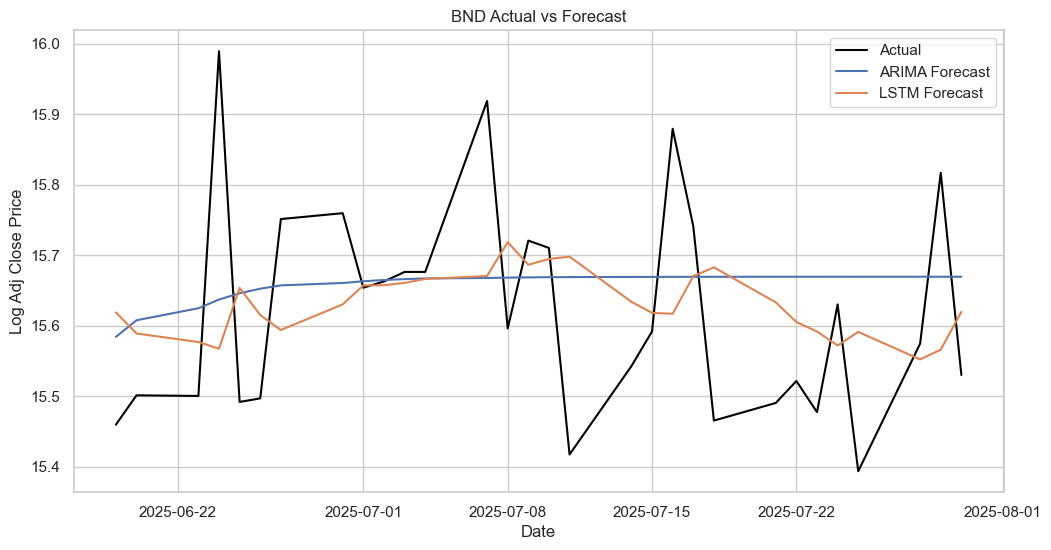

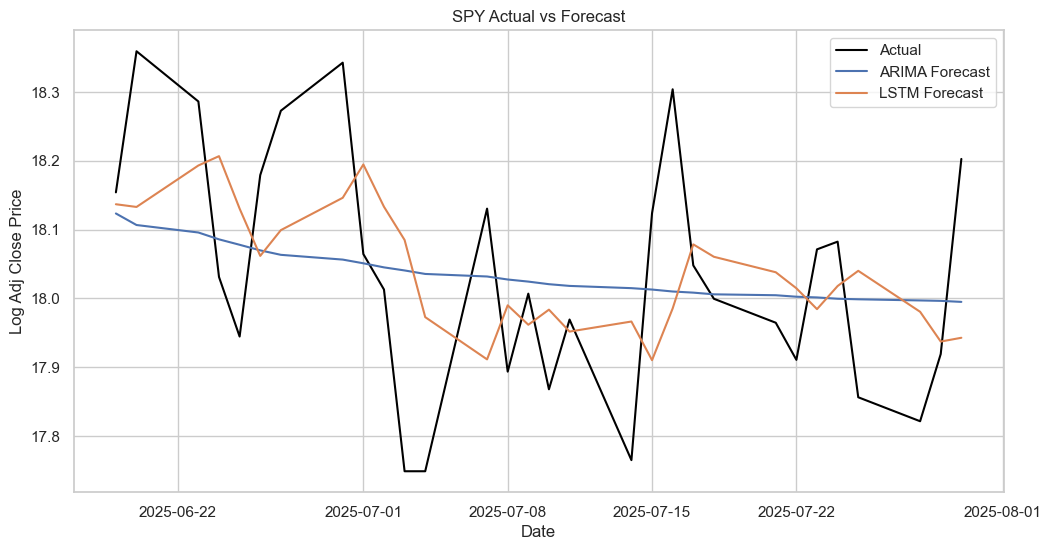

In [16]:
for ticker, df_forecast in zip(TICKERS, all_forecasts):
    plt.figure(figsize=(12,6))
    plt.plot(df_forecast.index, df_forecast["Actual"], label="Actual", color="black")
    plt.plot(df_forecast.index, df_forecast["ARIMA_Forecast"], label="ARIMA Forecast")
    plt.plot(df_forecast.index, df_forecast["LSTM_Forecast"], label="LSTM Forecast")
    plt.title(f"{ticker} Actual vs Forecast")
    plt.xlabel("Date")
    plt.ylabel("Log Adj Close Price")
    plt.legend()
    plt.show()